In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits import mplot3d
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates
from kneed import KneeLocator

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#PCA
from sklearn.decomposition import PCA
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df=pd.read_csv("ravdess_features.csv")

In [4]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])

In [5]:
df["vocal_channel_fill"]=df["vocal_channel"]
df["vocal_channel_fill"]=df["vocal_channel_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["intensity_fill"]=df["intensity"]
df["intensity_fill"]=df["intensity_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [6]:
df.corr().loc[["intensity_fill", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"], ["intensity_fill", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"]].style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

## Statistiche generali

<AxesSubplot:xlabel='stft_min', ylabel='Density'>

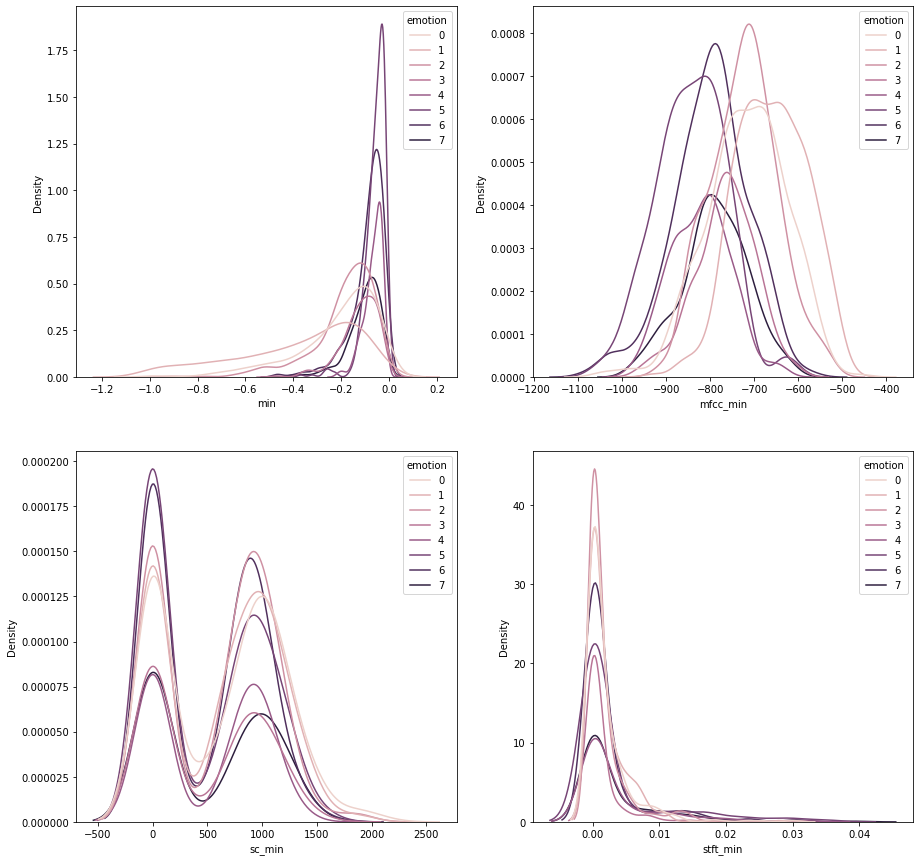

In [7]:
#min df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_min", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='intensity_fill', ylabel='Density'>

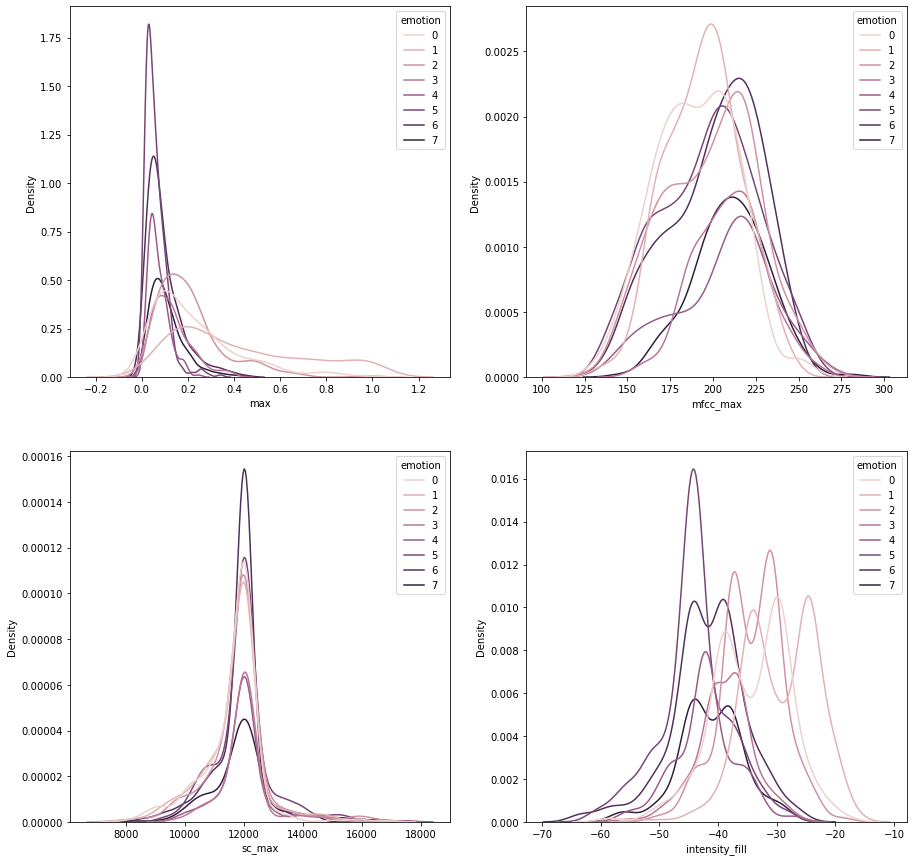

In [8]:
#max df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="max", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_max", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_max", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="intensity_fill", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_mean', ylabel='Density'>

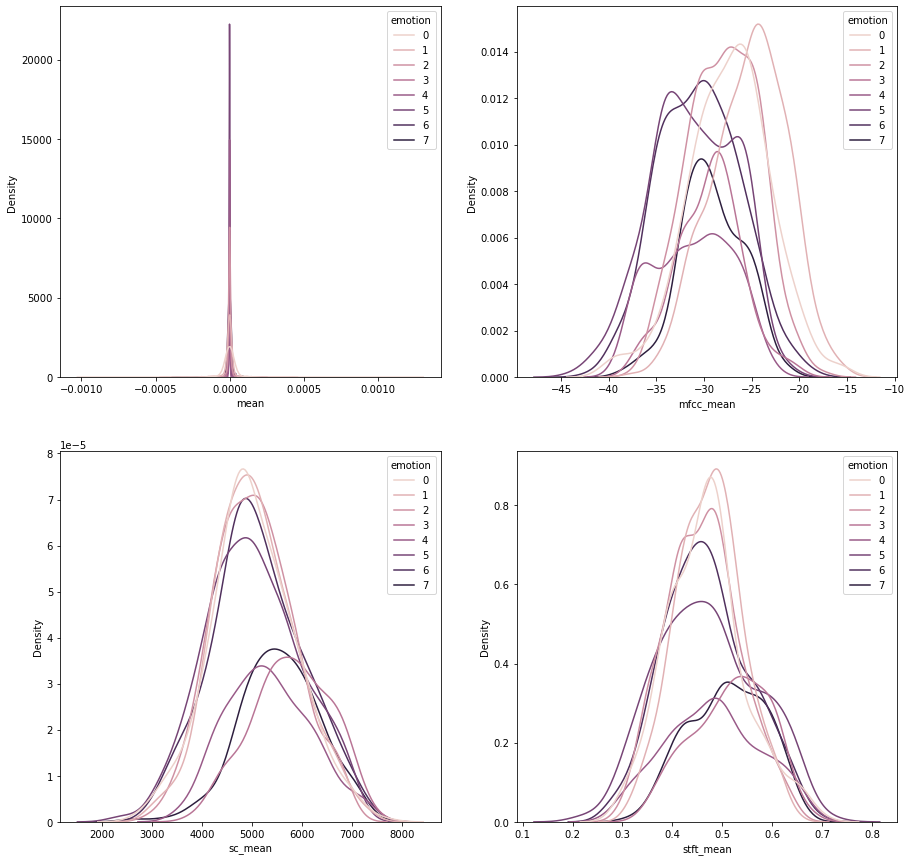

In [9]:
#mean df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_mean", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_std', ylabel='Density'>

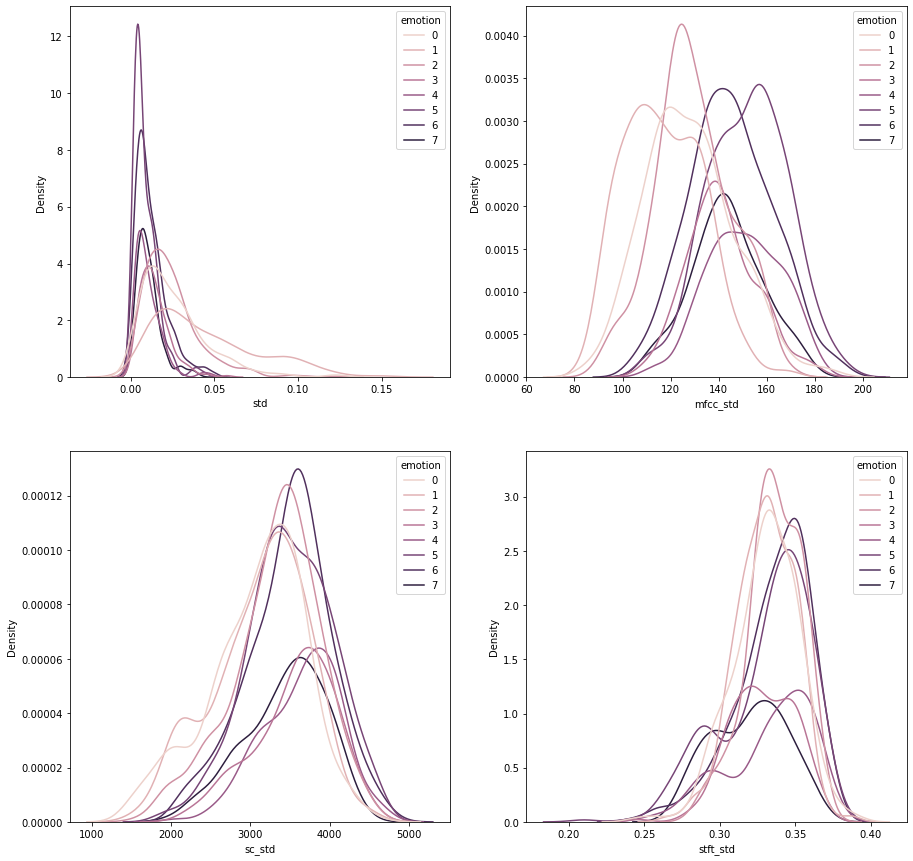

In [10]:
#std
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_std", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_skew', ylabel='Density'>

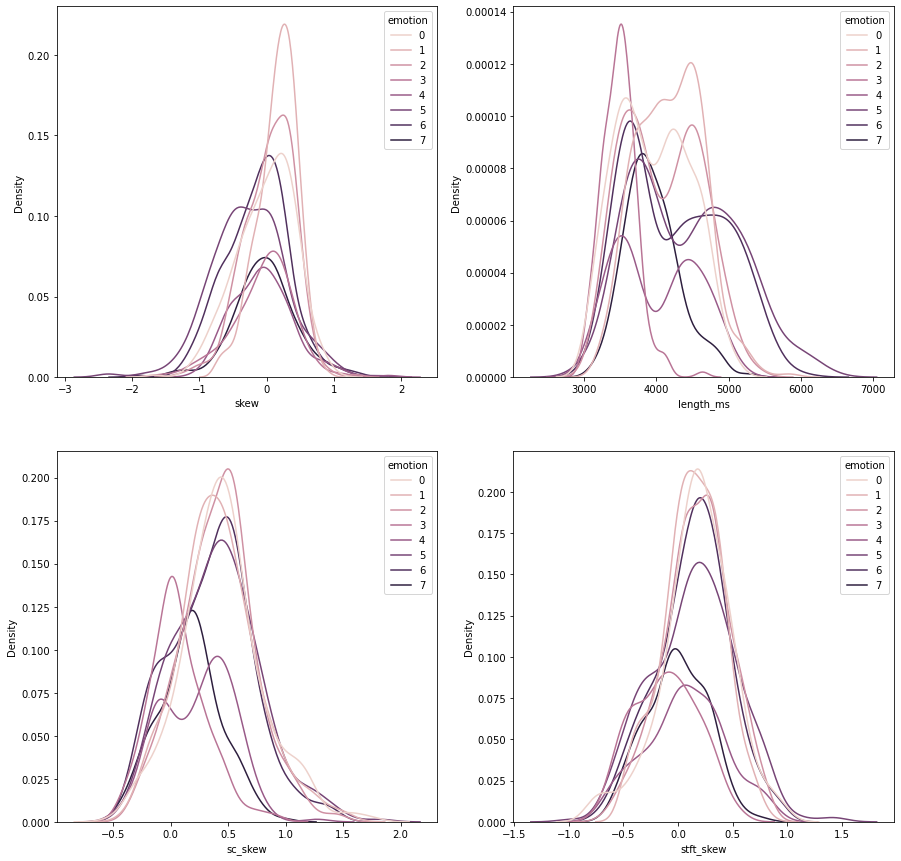

In [11]:
#skew and length
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_skew", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_kur', ylabel='Density'>

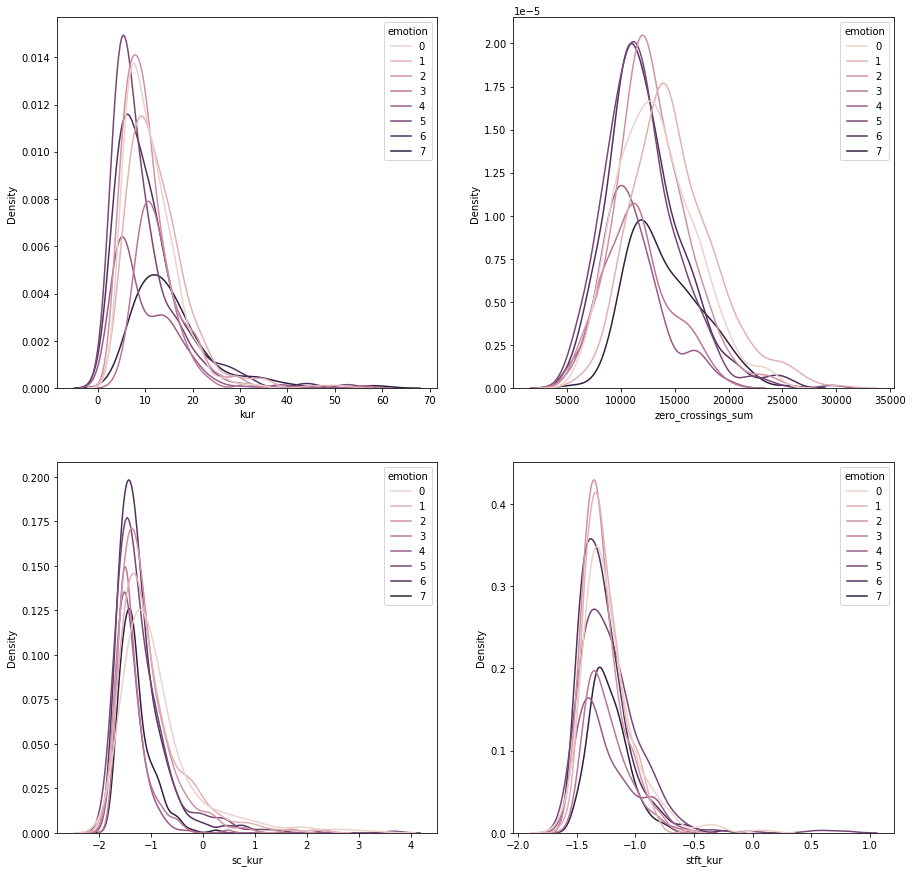

In [12]:
#zero-crossing-sum and kurtosis
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_kur", hue="emotion", ax=axs[1][1])

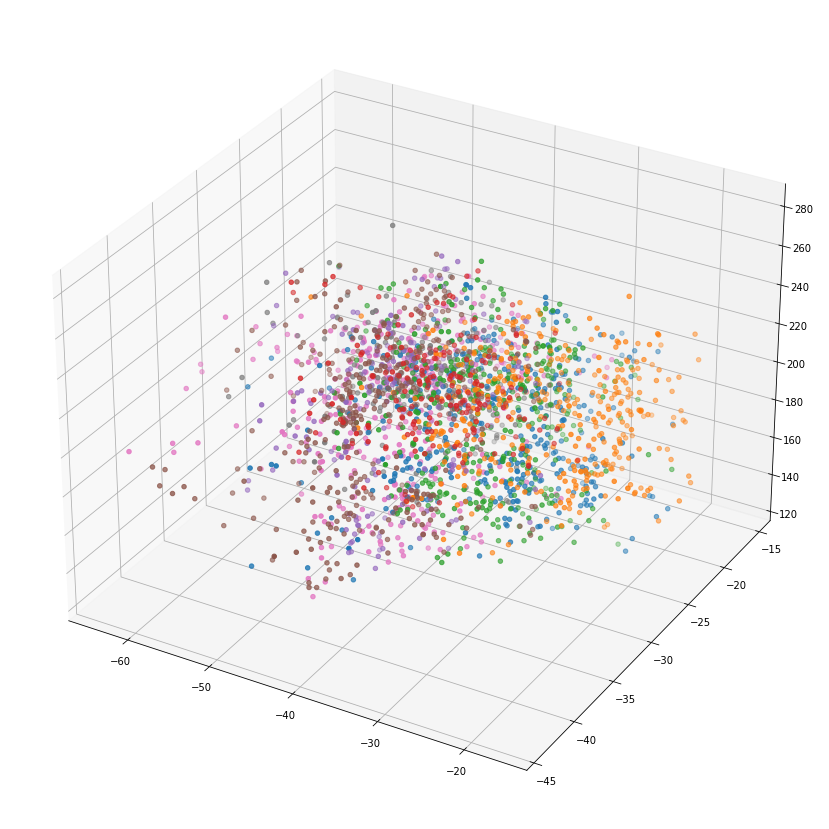

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.emotion.unique():
    ax.scatter(df.intensity_fill[df.emotion==s],df.mfcc_mean[df.emotion==s],df.mfcc_max[df.emotion==s],label=s)

## Outliers

In [14]:
#più interessanti
"""fig, axs = plt.subplots(5,2,figsize=(15,15))
sns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])
sns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])
sns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])
sns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])"""

'fig, axs = plt.subplots(5,2,figsize=(15,15))\nsns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])\nsns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])\nsns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])\nsns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])\nsns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])\nsns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])\nsns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])\nsns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])\nsns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])\nsns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])'

# Clustering

## Kmeans

In [15]:
#elimino le variabili non numeriche e inutili
df = df.drop(["emotion", "modality", "intensity", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max", "vocal_channel_fill", "frame_count"], axis=1)

In [16]:
dfcopy1=df.copy()
dfcopy2=df
dfcopy3=df

In [17]:
df.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [18]:
#elimino le variabili altamente correlate (>|0.8| per df, >|0.95| per dfcopy2, >|0.7| per dfcopy3)
df = df.drop(["mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min"],axis=1)
dfcopy2=dfcopy2.drop(["mfcc_std", "stft_skew", "std", "min"],axis=1)
dfcopy3 = dfcopy3.drop(["length_ms", "mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min", "sc_kur", "stft_std", "intensity_fill"],axis=1)

In [19]:
dfcopy3.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [20]:
dfcopy4 = dfcopy3.drop(["mean", "max", "kur", "skew"],axis=1)

In [21]:
dfcopy4.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [22]:
dfcopy3.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [23]:
X = df.values
X1 = dfcopy2.values
X2 = dfcopy3.values
X3 = dfcopy4.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
X_minmax1 = scaler.fit_transform(X1)
X_minmax2 = scaler.fit_transform(X2)
X_minmax3 = scaler.fit_transform(X3)

<AxesSubplot:ylabel='Count'>

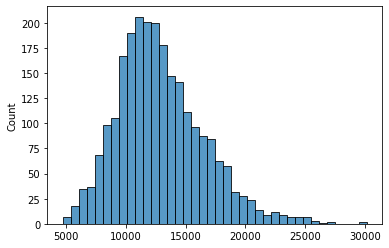

In [24]:
sns.histplot(data=X, x=X[:,1])

<AxesSubplot:ylabel='Count'>

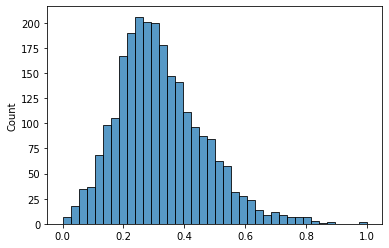

In [25]:
sns.histplot(data=X_minmax, x=X_minmax[:,1])

In [26]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=4)

<AxesSubplot:xlabel='intensity_fill', ylabel='mfcc_mean'>

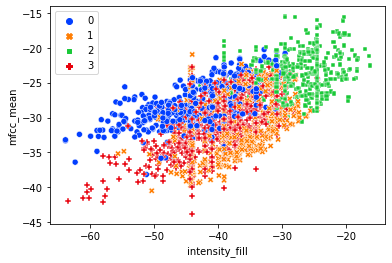

In [27]:
sns.scatterplot(data=df, x="intensity_fill", y="mfcc_mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [28]:
sse_list = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

In [29]:
sse_list1 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax1)
    sse_list1.append(kmeans.inertia_)

In [30]:
sse_list2 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax2)
    sse_list2.append(kmeans.inertia_)

In [31]:
sse_list3 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax3)
    sse_list3.append(kmeans.inertia_)

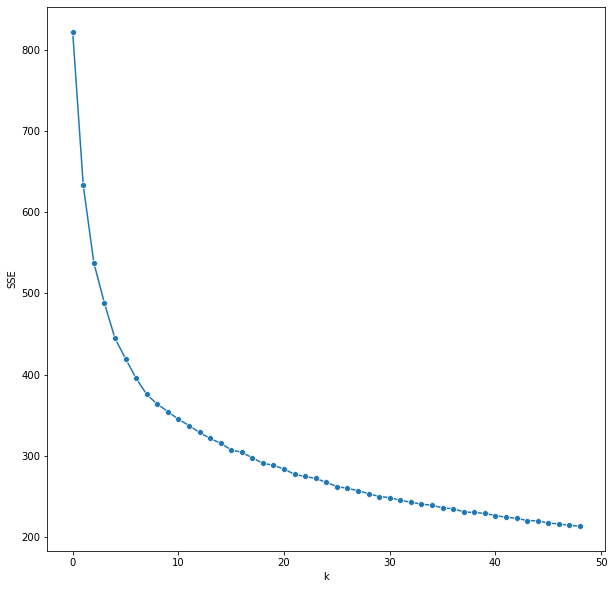

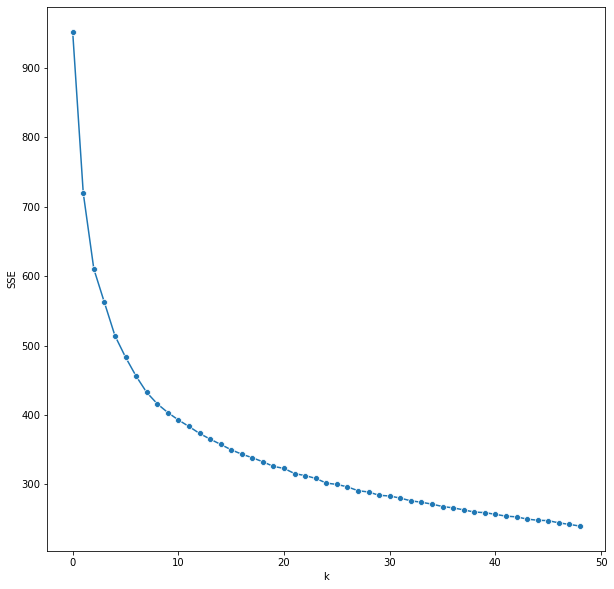

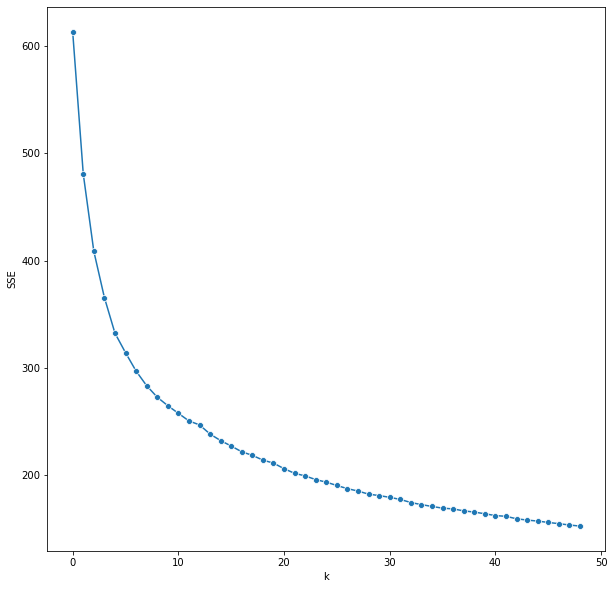

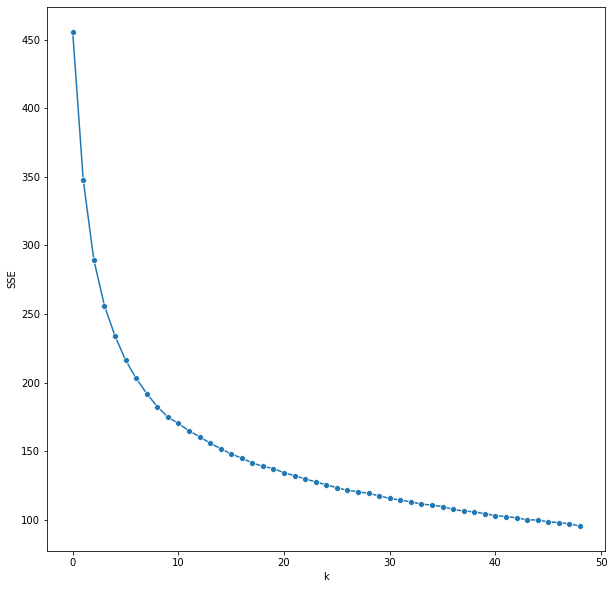

In [32]:
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list1)), y=sse_list1, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list2)), y=sse_list2, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list3)), y=sse_list3, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [33]:
#knee locator
kn = KneeLocator(range(len(sse_list)), sse_list, curve='convex', direction='decreasing')
print(kn.knee)

kn1 = KneeLocator(range(len(sse_list1)), sse_list1, curve='convex', direction='decreasing')
print(kn1.knee)

kn2 = KneeLocator(range(len(sse_list2)), sse_list2, curve='convex', direction='decreasing')
print(kn2.knee)

kn3 = KneeLocator(range(len(sse_list3)), sse_list3, curve='convex', direction='decreasing')
print(kn3.knee)

7
8
8
9


In [34]:
kmeans = KMeans(init='k-means++', n_clusters=kn.knee, n_init=10, max_iter=100)
kmeans.fit(X_minmax)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_minmax, kmeans.labels_))

kmeans1 = KMeans(init='k-means++', n_clusters=kn1.knee, n_init=10, max_iter=100)
kmeans1.fit(X_minmax1)
hist, bins = np.histogram(kmeans1.labels_, bins=range(0, len(set(kmeans1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans1.inertia_)
print('silhouette', silhouette_score(X_minmax1, kmeans1.labels_))

kmeans2 = KMeans(init='k-means++', n_clusters=kn2.knee, n_init=10, max_iter=100)
kmeans2.fit(X_minmax2)
hist, bins = np.histogram(kmeans2.labels_, bins=range(0, len(set(kmeans2.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans2.inertia_)
print('silhouette', silhouette_score(X_minmax2, kmeans2.labels_))

kmeans3 = KMeans(init='k-means++', n_clusters=kn3.knee, n_init=10, max_iter=100)
kmeans3.fit(X_minmax3)
hist, bins = np.histogram(kmeans3.labels_, bins=range(0, len(set(kmeans3.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans3.inertia_)
print('silhouette', silhouette_score(X_minmax3, kmeans3.labels_))

labels {0: 387, 1: 376, 2: 411, 3: 383, 4: 188, 5: 485, 6: 222}
sse 395.6279632263161
silhouette 0.17029173502770026
labels {0: 202, 1: 314, 2: 342, 3: 374, 4: 297, 5: 434, 6: 344, 7: 145}
sse 432.9026221068179
silhouette 0.15879049065899434
labels {0: 304, 1: 324, 2: 315, 3: 418, 4: 439, 5: 290, 6: 145, 7: 217}
sse 283.19884481385475
silhouette 0.16258285960476754
labels {0: 406, 1: 299, 2: 276, 3: 143, 4: 300, 5: 201, 6: 251, 7: 272, 8: 304}
sse 184.3456020921251
silhouette 0.17943328619947133


In [35]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
0       3737               16995 -33.485947  171.69092  3328.055457   
1       3904               13906 -29.502108  205.00770  4040.931570   
2       4671               18723 -30.532463  165.45653  3332.131300   
3       3637               11617 -36.059555  190.03609  4053.663073   
4       4404               15137 -31.405996  161.13400  3442.724109   

         sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
0  13541.959028 -1.120769  0.250940   0.415250  0.335533 -1.215025   
1  12000.290443 -1.531204  0.219582   0.417488  0.352380 -1.384174   
2  12007.751173 -1.130153  0.436699   0.379758  0.352270 -1.242947   
3  12048.223893 -1.497765  0.098802   0.407277  0.360552 -1.445318   
4  12025.582707 -1.167544  0.496066   0.415974  0.350655 -1.366742   

           mean       max        kur      skew  intensity_fill  \
0  3.844916e-07  0.138947   9.406061  0.273153      -36.793432   
1 -7.149491e-08  0.263062  19.564187  0.292157      -34.071849   
2  2.429985e-06  0.166351   4.881241  0.302659      -32.290737   
3  2.373929e-07  0.024078  13.040259 -0.081014      -49.019839   
4  8.454691e-07  0.242676   7.485109  0.414872      -31.214503   

   frame_count_fill  
0          179379.0  
1          187387.0  
2          224224.0  
3          174575.0  
4          211411.0

In [36]:
df["klabels"]=kmeans.labels_
dfcopy2["klabels"]=kmeans1.labels_
dfcopy3["klabels"]=kmeans2.labels_
dfcopy4["klabels"]=kmeans3.labels_

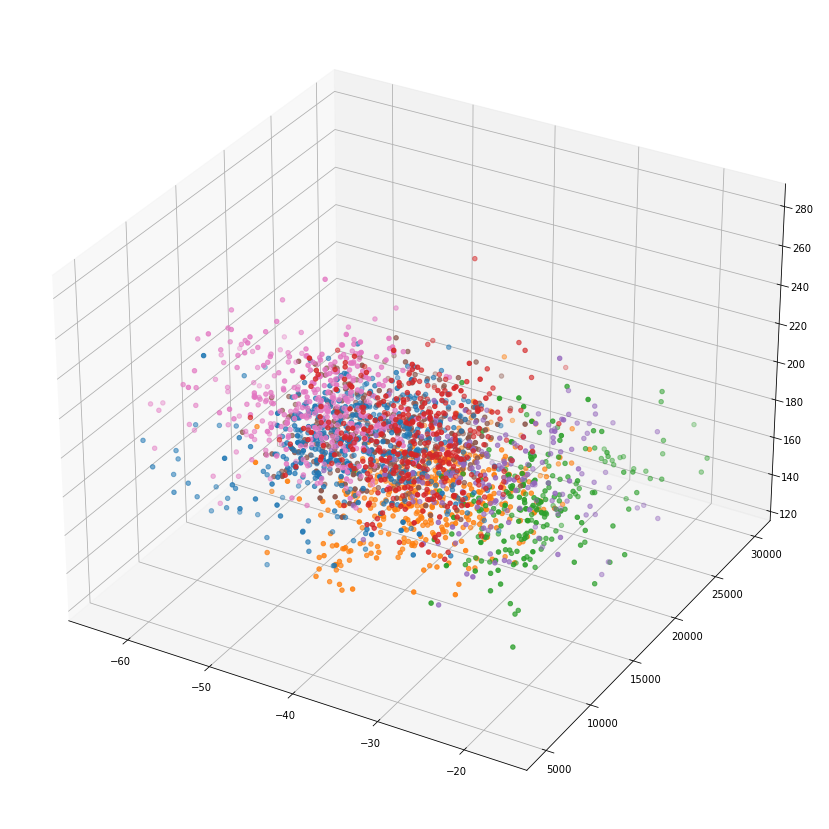

In [37]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(df.intensity_fill[df.klabels==s],df.zero_crossings_sum[df.klabels==s],df.mfcc_max[df.klabels==s],label=s)

<AxesSubplot:xlabel='intensity_fill', ylabel='mfcc_mean'>

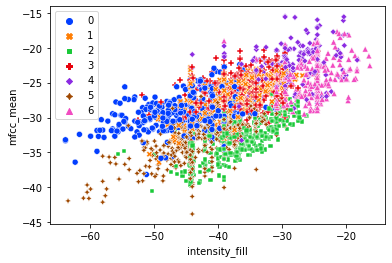

In [38]:
sns.scatterplot(data=df, x="intensity_fill", y="mfcc_mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [39]:
len(kmeans.cluster_centers_)

7

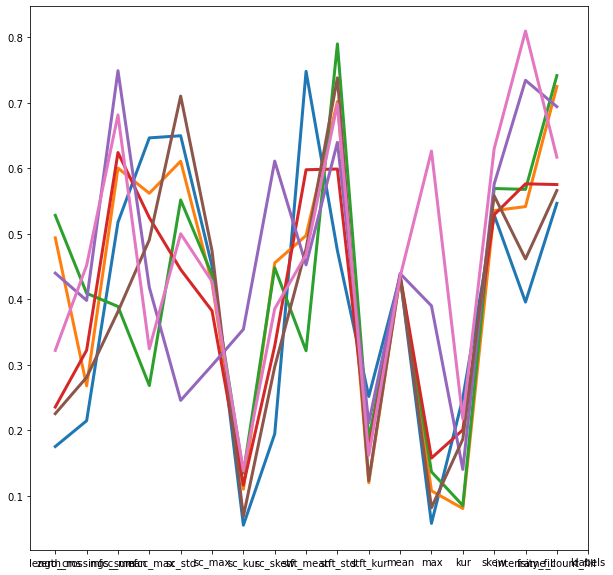

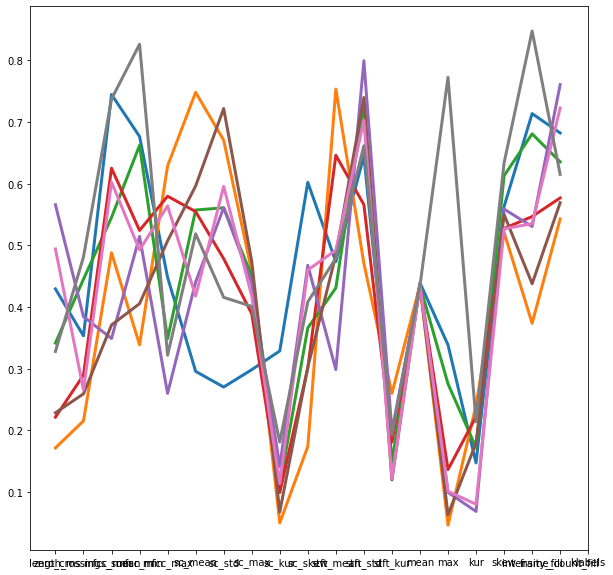

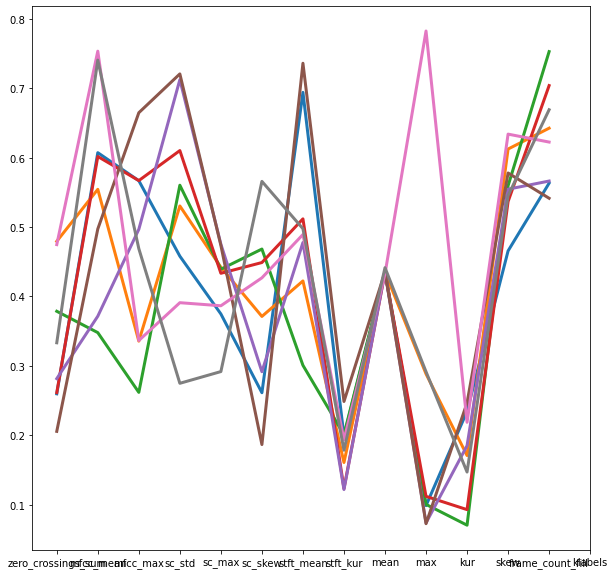

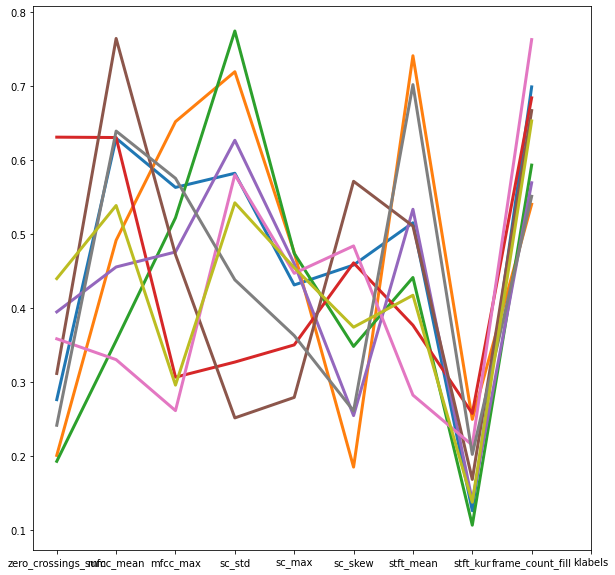

In [40]:
plt.figure(figsize=(10,10))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, len(kmeans.cluster_centers_[0])), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(df.columns)), list(df))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans1.cluster_centers_)):
    plt.plot(range(0, len(kmeans1.cluster_centers_[0])), kmeans1.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy2.columns)), list(dfcopy2))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans2.cluster_centers_)):
    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans3.cluster_centers_)):
    plt.plot(range(0, len(kmeans3.cluster_centers_[0])), kmeans3.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy4.columns)), list(dfcopy4))
plt.show()

### PCA analysis

([<matplotlib.axis.XTick at 0x7f33e4153880>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

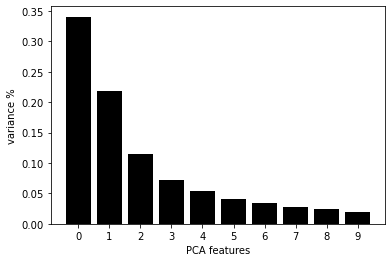

In [41]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_minmax)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

([<matplotlib.axis.XTick at 0x7f33dd316460>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

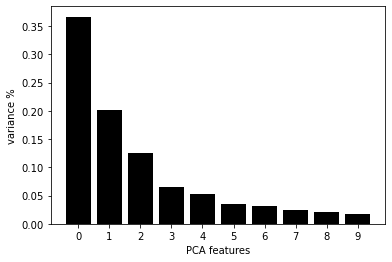

In [42]:
pca = PCA(n_components=10)
principal_components1 = pca.fit_transform(X_minmax1)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

([<matplotlib.axis.XTick at 0x7f33dd291d60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

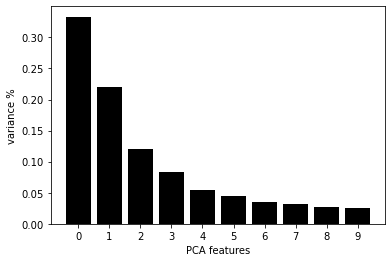

In [43]:
pca = PCA(n_components=10)
principal_components2 = pca.fit_transform(X_minmax2)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

([<matplotlib.axis.XTick at 0x7f33dd214340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

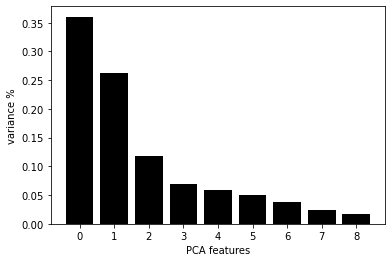

In [44]:
pca = PCA(n_components=9)
principal_components3 = pca.fit_transform(X_minmax3)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

2D PCA

In [45]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_minmax)
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)
principal_components3 = pca.fit_transform(X_minmax3)

principal2dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2"])
principal2dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2"])
principal2dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2"])
principal2dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2"])

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

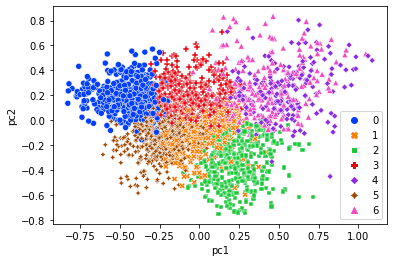

In [46]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=kmeans.labels_, style=kmeans.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

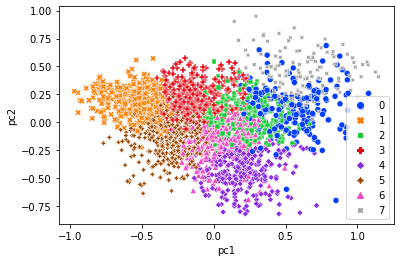

In [47]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=kmeans1.labels_, style=kmeans1.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

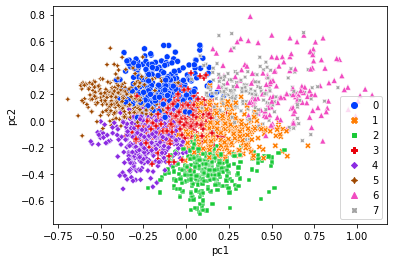

In [48]:
sns.scatterplot(data=principal2dDf2, x="pc1", y="pc2", hue=kmeans2.labels_, style=kmeans2.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

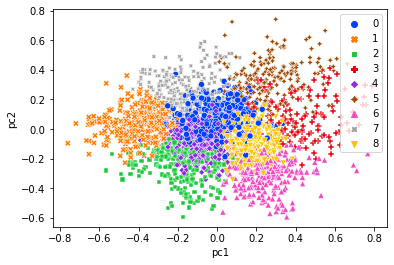

In [49]:
sns.scatterplot(data=principal2dDf3, x="pc1", y="pc2", hue=kmeans3.labels_, style=kmeans3.labels_, palette="bright")

3D PCA

In [50]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_minmax)
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)
principal_components3 = pca.fit_transform(X_minmax3)

principal3dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])
principal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])
principal3dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2", "pc3"])
principal3dDf3 = pd.DataFrame(data = principal_components3, columns = ["pc1", "pc2", "pc3"])

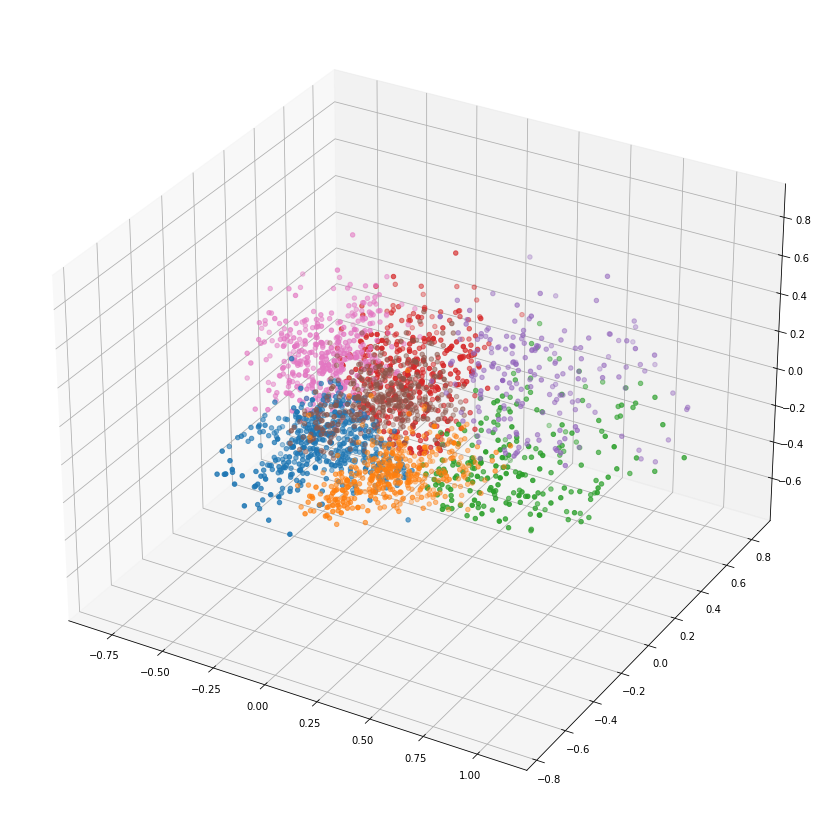

In [51]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(principal3dDf.pc1[df.klabels==s],principal3dDf.pc2[df.klabels==s],principal3dDf.pc3[df.klabels==s],label=s)

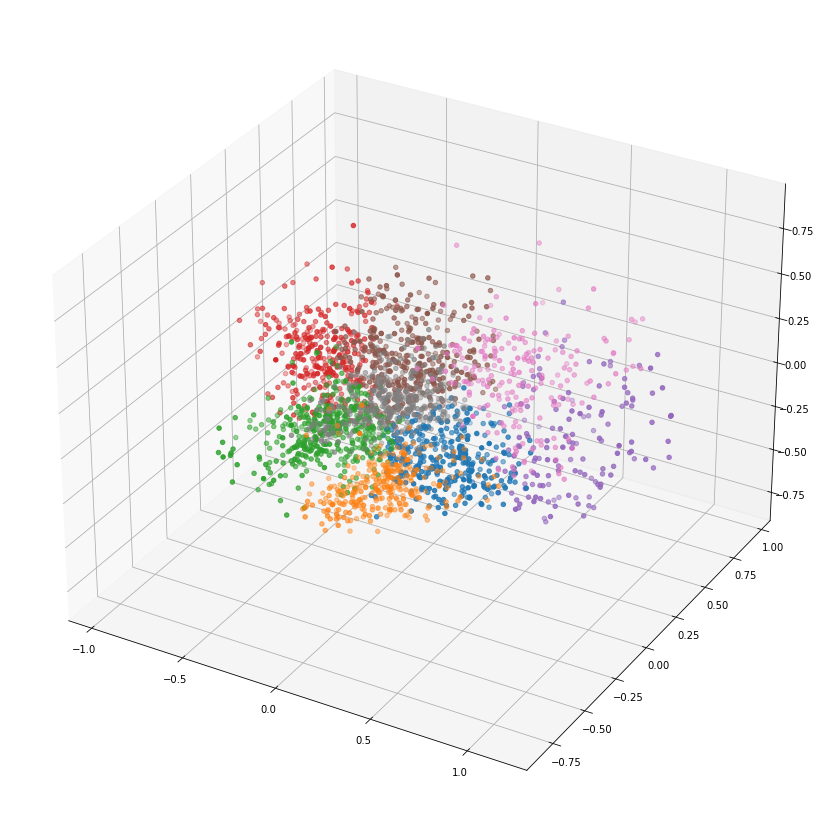

In [52]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy2.klabels.unique():
    ax.scatter(principal3dDf1.pc1[dfcopy2.klabels==s],principal3dDf1.pc2[dfcopy2.klabels==s],principal3dDf1.pc3[dfcopy2.klabels==s],label=s)

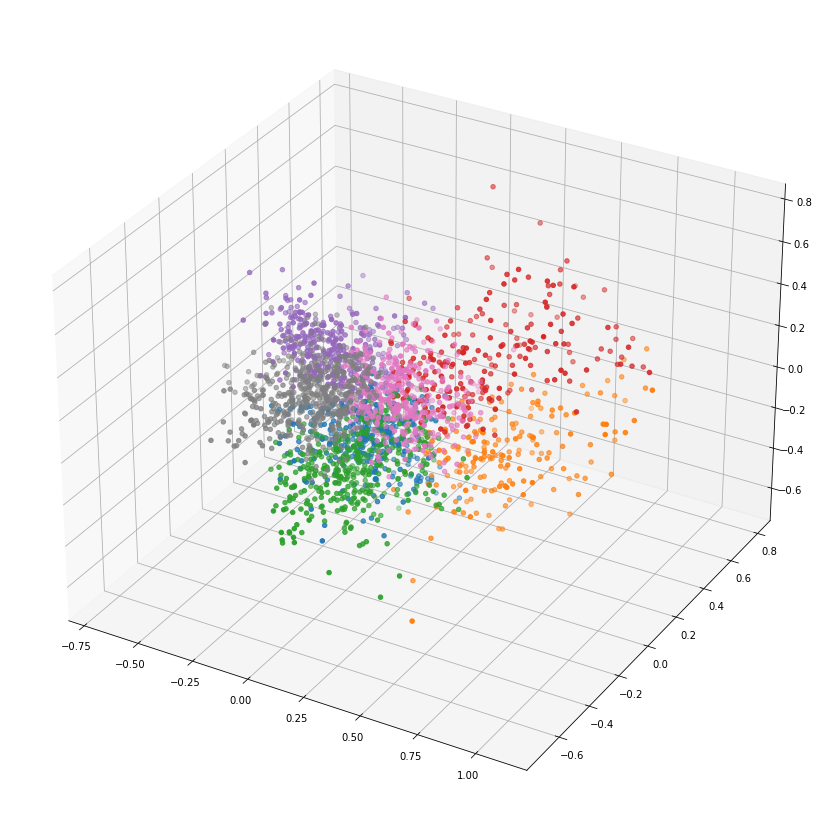

In [53]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy3.klabels.unique():
    ax.scatter(principal3dDf2.pc1[df.klabels==s],principal3dDf2.pc2[df.klabels==s],principal3dDf2.pc3[df.klabels==s],label=s)

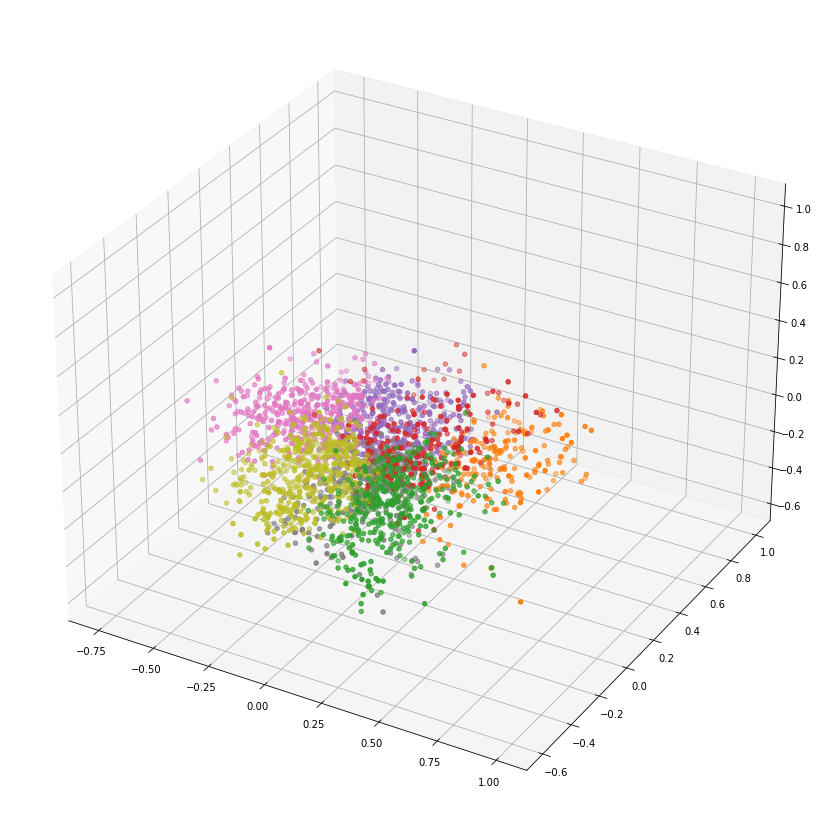

In [54]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy4.klabels.unique():
    ax.scatter(principal3dDf3.pc1[df.klabels==s],principal3dDf3.pc2[df.klabels==s],principal3dDf3.pc3[df.klabels==s],label=s)

In [55]:
principal3dDf["klabels"]=kmeans.labels_
principal3dDf1["klabels"]=kmeans1.labels_
principal3dDf2["klabels"]=kmeans2.labels_
principal3dDf3["klabels"]=kmeans3.labels_

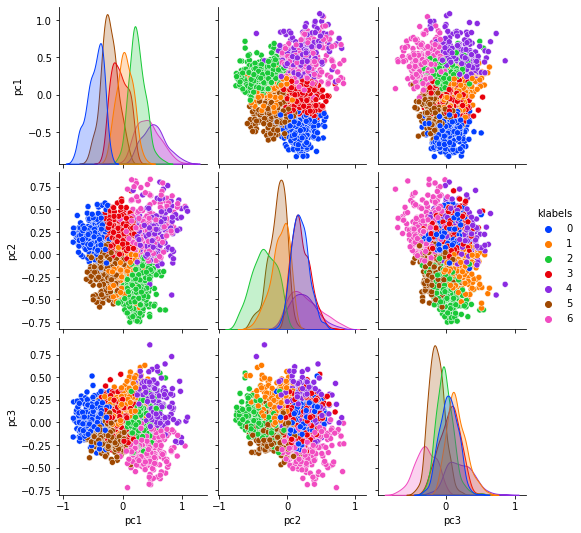

In [56]:
sns.pairplot(data=principal3dDf, hue="klabels", palette="bright")
plt.show()

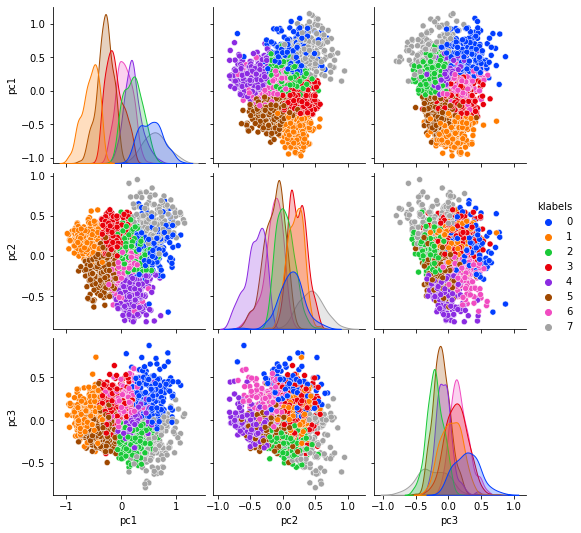

In [57]:
sns.pairplot(data=principal3dDf1, hue="klabels", palette="bright")
plt.show()

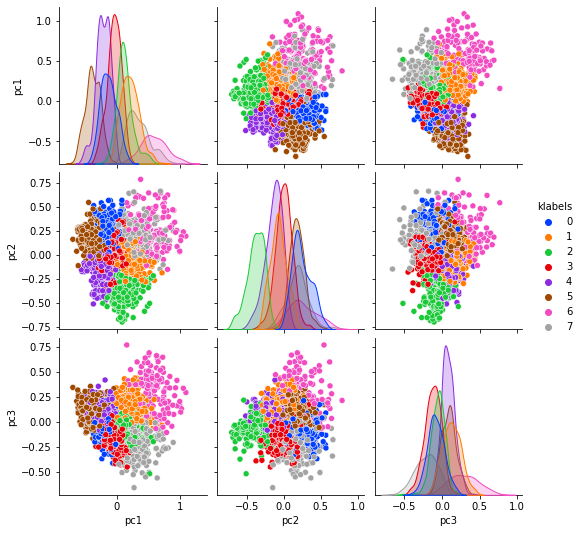

In [58]:
sns.pairplot(data=principal3dDf2, hue="klabels", palette="bright")
plt.show()

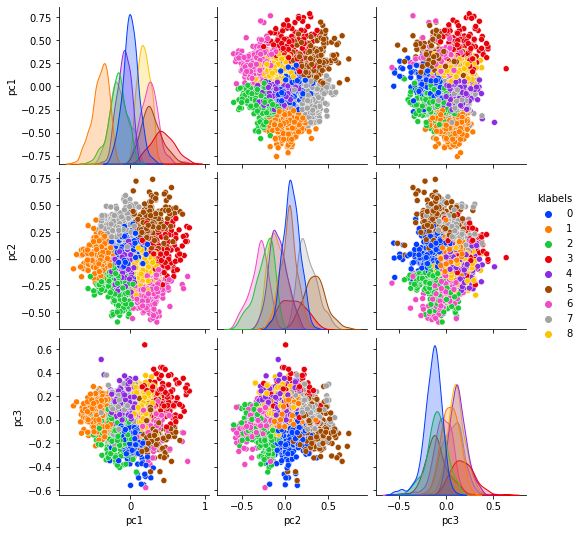

In [59]:
sns.pairplot(data=principal3dDf3, hue="klabels", palette="bright")
plt.show()

## DBScan

In [60]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
0       3737               16995 -33.485947  171.69092  3328.055457   
1       3904               13906 -29.502108  205.00770  4040.931570   
2       4671               18723 -30.532463  165.45653  3332.131300   
3       3637               11617 -36.059555  190.03609  4053.663073   
4       4404               15137 -31.405996  161.13400  3442.724109   

         sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
0  13541.959028 -1.120769  0.250940   0.415250  0.335533 -1.215025   
1  12000.290443 -1.531204  0.219582   0.417488  0.352380 -1.384174   
2  12007.751173 -1.130153  0.436699   0.379758  0.352270 -1.242947   
3  12048.223893 -1.497765  0.098802   0.407277  0.360552 -1.445318   
4  12025.582707 -1.167544  0.496066   0.415974  0.350655 -1.366742   

           mean       max        kur      skew  intensity_fill  \
0  3.844916e-07  0.138947   9.406061  0.273153      -36.793432   
1 -7.149491e-08  0.263062  19.564187  0.292157      -34.071849   
2  2.429985e-06  0.166351   4.881241  0.302659      -32.290737   
3  2.373929e-07  0.024078  13.040259 -0.081014      -49.019839   
4  8.454691e-07  0.242676   7.485109  0.414872      -31.214503   

   frame_count_fill  klabels  
0          179379.0        5  
1          187387.0        5  
2          224224.0        2  
3          174575.0        5  
4          211411.0        2

In [61]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

dist1 = pdist(X_minmax1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_minmax2, 'euclidean')
dist2 = squareform(dist2)

dist3 = pdist(X_minmax3, 'euclidean')
dist3 = squareform(dist3)

In [62]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

kth_distances1 = []
for d in dist1:
    index_kth_distance = np.argsort(d)[k] 
    kth_distances1.append(d[index_kth_distance])  

kth_distances2 = []
for d in dist2: 
    index_kth_distance = np.argsort(d)[k]  
    kth_distances2.append(d[index_kth_distance]) 
    
kth_distances3 = []
for d in dist3: 
    index_kth_distance = np.argsort(d)[k]  
    kth_distances3.append(d[index_kth_distance])

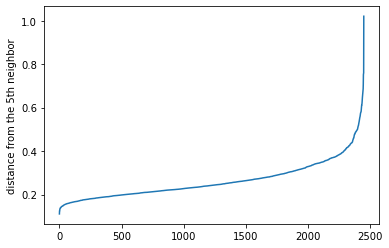

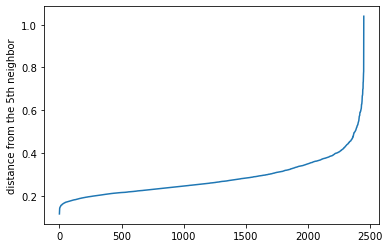

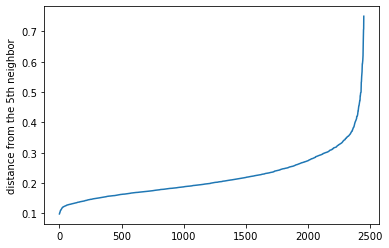

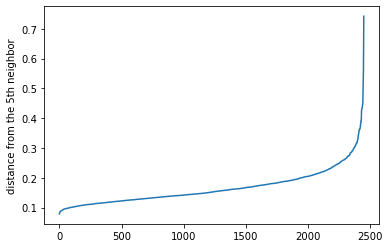

In [63]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances1)), sorted(kth_distances1))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances2)), sorted(kth_distances2))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances3)), sorted(kth_distances3))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

In [64]:
#knee locator
kn = KneeLocator(range(len(kth_distances)), sorted(kth_distances), curve='convex', direction='increasing')
optimal_eps=np.interp(kn.knee, range(len(kth_distances)), sorted(kth_distances))
optimal_eps

0.47974271096137067

In [65]:
kn = KneeLocator(range(len(kth_distances1)), sorted(kth_distances1), curve='convex', direction='increasing')
optimal_eps1=np.interp(kn.knee, range(len(kth_distances1)), sorted(kth_distances1))
optimal_eps1

0.4955921253532071

In [66]:
kn = KneeLocator(range(len(kth_distances2)), sorted(kth_distances2), curve='convex', direction='increasing')
optimal_eps2=np.interp(kn.knee, range(len(kth_distances2)), sorted(kth_distances2))
optimal_eps2

0.41945287018225974

In [67]:
kn = KneeLocator(range(len(kth_distances3)), sorted(kth_distances3), curve='convex', direction='increasing')
optimal_eps3=np.interp(kn.knee, range(len(kth_distances3)), sorted(kth_distances3))
optimal_eps3

0.36173878897481243

In [68]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(X_minmax)
hist, bins = np.histogram(dbscan.labels_, bins=range(0, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax, dbscan.labels_))

dbscan1 = DBSCAN(eps=optimal_eps1, min_samples=5)
dbscan1.fit(X_minmax1)
hist, bins = np.histogram(dbscan1.labels_, bins=range(0, len(set(dbscan1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax1, dbscan1.labels_))

dbscan2 = DBSCAN(eps=optimal_eps2, min_samples=5)
dbscan2.fit(X_minmax2)
hist, bins = np.histogram(dbscan2.labels_, bins=range(0, len(set(dbscan2.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax2, dbscan2.labels_))

dbscan3 = DBSCAN(eps=optimal_eps3, min_samples=5)
dbscan3.fit(X_minmax3)
hist, bins = np.histogram(dbscan3.labels_, bins=range(0, len(set(dbscan3.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax3, dbscan3.labels_))

labels {0: 2407, 1: 22, 2: 0}
silhouette 0.20086472965686758
labels {0: 2406, 1: 21, 2: 0}
silhouette 0.1725519584821791
labels {0: 2410, 1: 24, 2: 0}
silhouette 0.2592817856683492
labels {0: 2413, 1: 25, 2: 0}
silhouette 0.3178206400462459


In [69]:
df["dbscan_labels"]=dbscan.labels_
dfcopy2["dbscan_labels"]=dbscan1.labels_
dfcopy3["dbscan_labels"]=dbscan2.labels_
dfcopy4["dbscan_labels"]=dbscan3.labels_

In [70]:
sorted_df = df.sort_values(by="dbscan_labels")
sorted_df1 = dfcopy2.sort_values(by="dbscan_labels")
sorted_df2 = dfcopy3.sort_values(by="dbscan_labels")
sorted_df3 = dfcopy4.sort_values(by="dbscan_labels")
sorted_df

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
1839       3103                6713 -32.365597  212.89236  4589.487973   
2102       3437                8605 -36.383682  207.41885  3696.121989   
1797       3337                6427 -20.810501  201.45715  2354.869904   
971        4204                8610 -26.230085  179.63490  2895.122294   
1288       4104               16701 -29.040232  197.99615  3270.221246   
...         ...                 ...        ...        ...          ...   
1427       3537               13077 -29.124308  183.37820  3624.155925   
2245       4338               13251 -31.049019  191.87555  3491.013361   
869        3770               12087 -32.684746  219.09021  3995.252011   
1238       4471               12683 -26.245222  194.41292  3883.486083   
2311       4972               17726 -31.388168  180.46005  2794.673170   

            sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
1839  12009.582839 -1.665097  0.108862   0.507055  0.359324 -1.453457   
2102  12079.288790 -1.207742 -0.365248   0.648529  0.266053 -0.246777   
1797  10808.879804 -0.853370  0.451838   0.650883  0.298777 -0.826186   
971   12139.201237  2.757149  1.746726   0.399148  0.387775 -1.510728   
1288  12028.687805 -1.387789  0.014570   0.635033  0.276974 -0.996192   
...            ...       ...       ...        ...       ...       ...   
1427  11925.628718 -1.245150  0.334428   0.359251  0.348048 -1.172609   
2245  12000.000156 -1.084673  0.488453   0.385101  0.359981 -1.377848   
869   14129.867514 -1.484232  0.271769   0.403030  0.349477 -1.342223   
1238  12094.995554 -1.458286  0.466744   0.483000  0.338388 -1.448095   
2311  12218.724745 -1.142735  0.371654   0.426616  0.354889 -1.389472   

              mean       max        kur      skew  intensity_fill  \
1839  5.531924e-09  0.072662  13.926762  0.631559      -43.036759   
2102  1.343066e-07  0.011932  55.833812 -0.455829      -62.350199   
1797 -9.435575e-04  0.291412  15.353364 -0.710158      -29.580034   
971   3.898423e-05  0.254364   7.557264  0.299472      -30.892766   
1288  3.124614e-06  0.054779  57.312606 -1.377390      -49.560469   
...            ...       ...        ...       ...             ...   
1427  1.517170e-07  0.377563  11.052940  0.380899      -28.391670   
2245 -2.865493e-06  0.144623   8.344269  0.189613      -36.225988   
869   2.369155e-07  0.144501  21.449223  0.607727      -38.355095   
1238  2.539209e-06  0.125488   8.091365 -0.415216      -35.040439   
2311 -1.480366e-06  0.184021  18.089279  0.171321      -39.075631   

      frame_count_fill  klabels  dbscan_labels  
1839              -1.0        5             -1  
2102          164964.0        0             -1  
1797          160160.0        3             -1  
971           201802.0        4             -1  
1288          196997.0        0             -1  
...                ...      ...            ...  
1427              -1.0        6              1  
2245              -1.0        5              1  
869               -1.0        5              1  
1238              -1.0        5              1  
2311              -1.0        3              1  

[2452 rows x 19 columns]

In [71]:
X_val=sorted_df.values
X_val1=sorted_df1.values
X_val2=sorted_df2.values
X_val3=sorted_df3.values

In [72]:
dist = pdist(X_val, 'euclidean')
dist = squareform(dist)

dist1 = pdist(X_val1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_val2, 'euclidean')
dist2 = squareform(dist2)

dist3 = pdist(X_val3, 'euclidean')
dist3 = squareform(dist3)

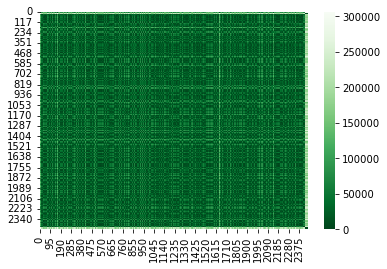

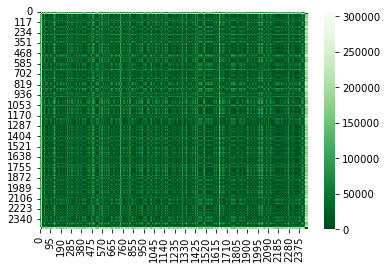

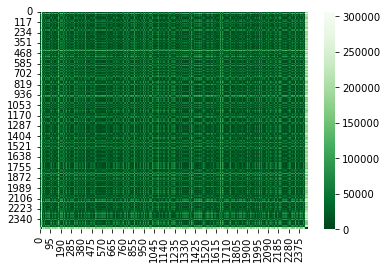

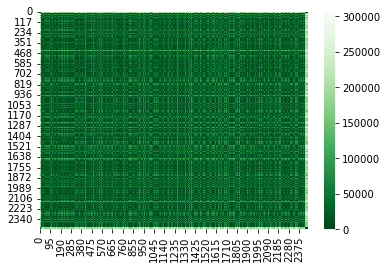

In [73]:
sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist1, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist2, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist3, cmap="Greens_r", annot=False)
plt.show()

## Hierarchical clustering

In [74]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Ward linkage

In [84]:
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)

model1_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)

model2_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model2_ward = model2_ward.fit(X_minmax2)

model3_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model3_ward = model3_ward.fit(X_minmax3)

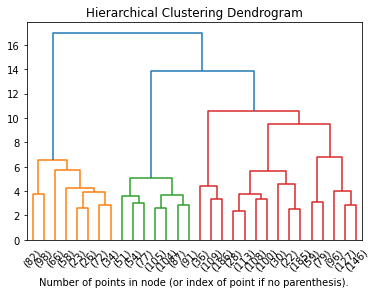

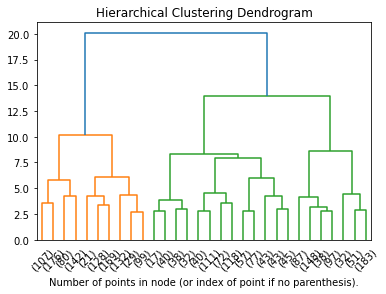

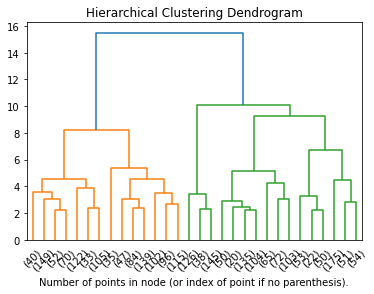

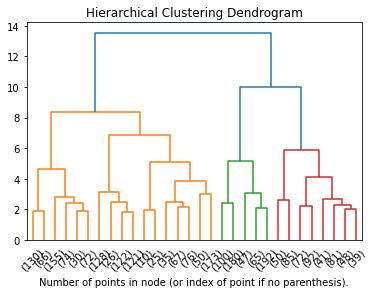

In [85]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

<AxesSubplot:xlabel='intensity_fill', ylabel='mfcc_mean'>

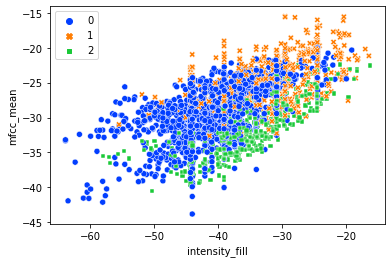

In [88]:
model3_ward = AgglomerativeClustering(distance_threshold=None, n_clusters=3, affinity='euclidean', linkage='ward')
model3_ward = model3_ward.fit(X_minmax3)

sns.scatterplot(data=df, x="intensity_fill", y="mfcc_mean", hue=model3_ward.labels_, style=model3_ward.labels_,
                palette="bright")

### Average linkage

In [89]:
model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model_avg = model_avg.fit(X_minmax)

model1_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model1_avg = model1_avg.fit(X_minmax1)

model2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model2_avg = model2_avg.fit(X_minmax2)

model3_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model3_avg = model3_avg.fit(X_minmax3)

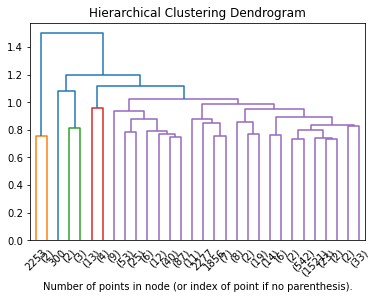

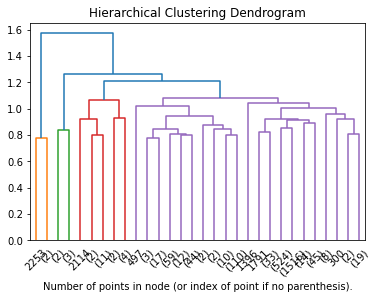

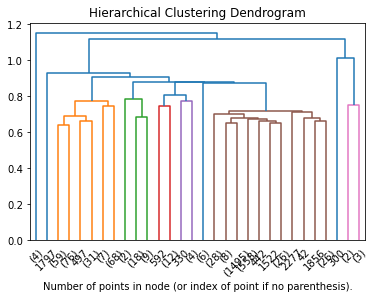

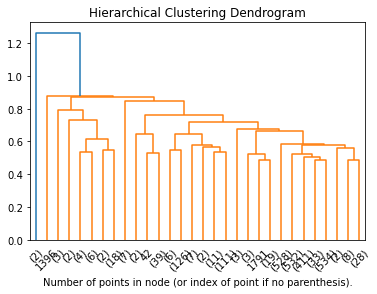

In [90]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Maximum linkage

In [91]:
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(X_minmax)

model1_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model1_complete = model1_complete.fit(X_minmax1)

model2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model2_complete = model2_complete.fit(X_minmax2)

model3_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model3_complete = model3_complete.fit(X_minmax3)

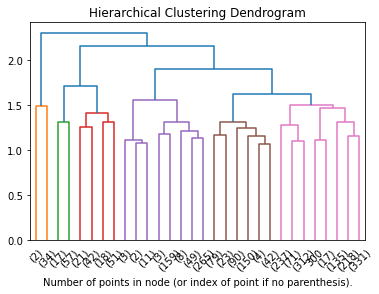

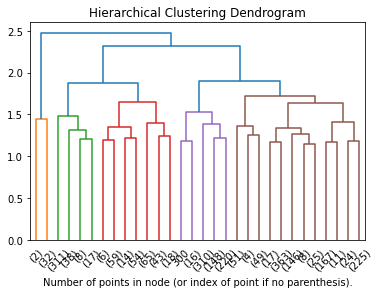

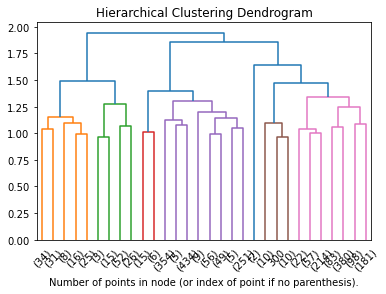

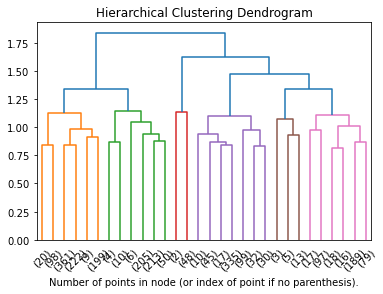

In [92]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Minimum

In [93]:
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model_single = model_single.fit(X_minmax)

model1_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model1_single = model1_single.fit(X_minmax1)

model2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model2_single = model2_single.fit(X_minmax2)

model3_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model3_single = model3_single.fit(X_minmax3)

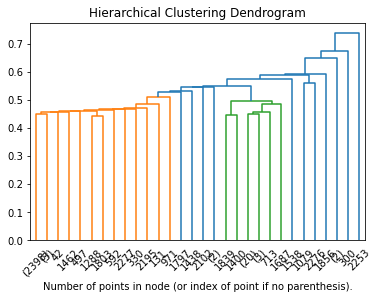

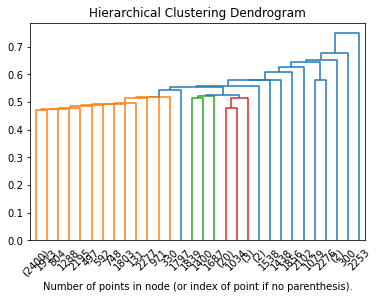

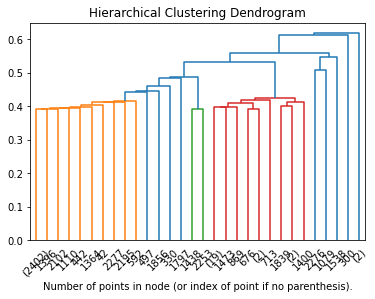

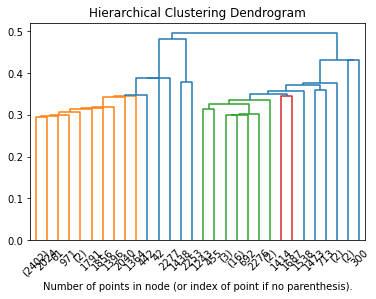

In [94]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model3_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()